In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np 
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 

In [ ]:
!pip install pyspellchecker==0.6.2 git+https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git


  Cloning https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git to /tmp/pip-req-build-o6wr2ach
  Running command git clone -q https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git /tmp/pip-req-build-o6wr2ach
     |████████████████████████████████| 2.7 MB 7.1 MB/s 
  Created wheel for FrenchLefffLemmatizer: filename=FrenchLefffLemmatizer-0.3-py3-none-any.whl size=3533527 sha256=4647e591558cd49a06a6cff037824a259f1ba641f6dd298a43320d71d564ebf2
  Stored in directory: /tmp/pip-ephem-wheel-cache-f6x1syc1/wheels/ba/24/e1/a774b7bba29a14b3f6b291d16e92563c745aa4f4d6901a0af7
Successfully built FrenchLefffLemmatizer


In [ ]:
import re
from spellchecker import SpellChecker

import nltk
nltk.download('stopwords')
nltk.download('punkt')
french_stopwords = nltk.corpus.stopwords.words('french')
french_stopwords.remove('l') # litre

from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer
lemmatizer = FrenchLefffLemmatizer()


class Items():


    def __init__(self, path):
        # load data
        self.df = pd.read_csv(path)
        # remove unlabelled data
        self.df = self.df[self.df['category'].str.len()>1]
        # clean data
        self.clean()
        # train_test split
        self.split()
        # vectorize 
        self.vectorize()

    def clean(self):
        self.df['Product_Designation'] = [self.clean_text(str(text)) for text in self.df['Product_Designation']]
        self.df['supplier_name'] = [self.clean_text(str(text)) for text in self.df['supplier_name']]
        self.df['full_designation'] = [self.df['Product_Designation'].values[i]+" "+self.df['supplier_name'].values[i] for i in range(self.df.shape[0])]

    def clean_text(self, text):
        """
        Applies some pre-processing on the given text
        """
        # convert text to lowercase
        text = text.lower()

        # remove numbers, symbols and ponctuation
        text = re.sub(r"[^A-Za-z]", " ", text)

        # remove leading whitespaces
        text = text.strip()

        # remove stop words
        tokenize_sentence = nltk.tokenize.word_tokenize(text)
        words_w_stopwords = [i for i in tokenize_sentence if i not in french_stopwords]

        # lemitization
        words_lemmatize = (lemmatizer.lemmatize(w) for w in words_w_stopwords)
        text = ' '.join(w for w in words_lemmatize)

        # spell check
        #spell = SpellChecker(language='fr')
        #text = spell.correction(text)

        return text

    def split(self):
        X = self.df['full_designation']
        y = self.df['category']

        from sklearn.model_selection import train_test_split
        self.X_train, self.X_valid, self.y_train, self.y_valid = train_test_split(X, y, test_size=0.2, stratify=self.df['category'], random_state=13)

    def vectorize(self):
        from sklearn.feature_extraction.text import CountVectorizer
        ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
                    ngram_range=(1, 1))
        corpus = self.X_train
        ctv.fit(corpus)
        self.X_train =  ctv.transform(self.X_train) 
        self.X_valid = ctv.transform(self.X_valid)

        from sklearn.preprocessing import LabelEncoder
        lbl_enc = LabelEncoder()
        self.y_train = lbl_enc.fit_transform(self.y_train)
        self.y_valid = lbl_enc.fit_transform(self.y_valid)
        self.label_map = dict(zip(lbl_enc.transform(lbl_enc.classes_),lbl_enc.classes_))

    def switch_device(self):
        if torch.cuda.is_available():
            device = torch.device("cuda:0")
            print("running on the GPU")
        else:
            device = torch.device("cpu")
            print("running on the CPU")

        self.X_train = torch.from_numpy(self.X_train.toarray())
        self.X_valid = torch.from_numpy(self.X_valid.toarray())
        self.y_train = torch.from_numpy(self.y_train)
        self.y_valid = torch.from_numpy(self.y_valid)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Data = Items('./data/annotated_data.csv')
Data = Items('/content/drive/MyDrive/Back-up/invoice-document-classification/data/annotated_data.csv')


BATCH_SIZE = 1
workers = 2

X_train_load = torch.utils.data.DataLoader(Data.X_train.toarray(), batch_size=BATCH_SIZE, num_workers=workers)
X_valid_load = torch.utils.data.DataLoader(Data.X_valid.toarray(), batch_size=BATCH_SIZE, num_workers=workers) 
y_train_load = torch.utils.data.DataLoader(Data.y_train, batch_size=BATCH_SIZE, num_workers=workers) 
y_valid_load = torch.utils.data.DataLoader(Data.y_valid, batch_size=BATCH_SIZE, num_workers=workers) 

In [ ]:
class Network(nn.Module):


    def __init__(self, input_shape):
        super().__init__()
        self.Dense1 = nn.Linear(input_shape, 512)
        self.Dropout = nn.Dropout(0.4)
        self.Dense2 = nn.Linear(512, out_features=15) # n categ

    def forward(self, x):
        x = F.relu(self.Dense1(x))
        x = F.relu(self.Dropout(x))
        x = self.Dense2(x)
        return x 


net = Network(Data.X_train.shape[1])

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("running on the GPU")
else:
    device = torch.device("cpu")
    print("running on the CPU")

running on the GPU


In [ ]:
net.to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

In [ ]:
# train

EPOCHS = 15
stats = {
    'loss': [],
    'acc': [],
    'val_loss': [],
    'val_acc': []
}

for epoch in range(EPOCHS):
    print(f"** Epoch: {epoch} **")
    # training
    net.train()
    correct, total = 0, 0
    for batch_x, batch_y in tqdm(zip(X_train_load, y_train_load), total=len(y_train_load)):
        # loading data on device
        batch_x = batch_x.to(device, dtype= torch.float)
        batch_y = batch_y.to(device)
        # Compute prediction and loss
        output = net(batch_x) 
        loss = loss_function(output, batch_y)
        # Backpropagation
        net.zero_grad()
        loss.backward()
        optimizer.step()
        # compute accuracy
        real_class = batch_y
        pred_class = torch.argmax(net(batch_x))
        if pred_class == real_class:
            correct += 1
        total += 1
    acc = round(correct/total, 3)
    print(f"Accuracy: {acc}")
    print(f"Loss: {loss}")
    
    # validation
    net.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch_x, batch_y in tqdm(zip(X_valid_load, y_valid_load), total=len(y_valid_load)):
            # loading data on device           
            batch_x = batch_x.to(device, dtype= torch.float)
            batch_y = batch_y.to(device)
            # Compute prediction and loss
            output = net(batch_x)
            val_loss = loss_function(output, batch_y)
            # compute accuracy
            real_class = batch_y
            pred_class = torch.argmax(output)
            if pred_class == real_class:
                correct += 1
            total += 1
    val_acc = round(correct/total, 3)
    
    print(f"Val_acc: {val_acc}")
    print(f"Val_Loss: {val_loss}")

    # metrics
    stats['acc'].append(acc)
    stats['loss'].append(loss)
    stats['val_acc'].append(val_acc)
    stats['val_loss'].append(val_loss)

** Epoch: 0 **


100%|██████████| 1815/1815 [00:06<00:00, 276.31it/s]

Accuracy: 0.705
Loss: 0.007370778359472752



100%|██████████| 454/454 [00:00<00:00, 489.37it/s]

Val_acc: 0.896
Val_Loss: 1.5475300550460815
** Epoch: 1 **



100%|██████████| 1815/1815 [00:06<00:00, 291.20it/s]


Accuracy: 0.96
Loss: 0.00048387263086624444


100%|██████████| 454/454 [00:00<00:00, 487.64it/s]

Val_acc: 0.921
Val_Loss: 0.26492825150489807
** Epoch: 2 **



100%|██████████| 1815/1815 [00:06<00:00, 290.88it/s]


Accuracy: 0.987
Loss: 4.8397800128441304e-05


100%|██████████| 454/454 [00:00<00:00, 507.48it/s]


Val_acc: 0.932
Val_Loss: 0.31698930263519287
** Epoch: 3 **


100%|██████████| 1815/1815 [00:06<00:00, 295.06it/s]


Accuracy: 0.997
Loss: 3.7431014789035544e-05


100%|██████████| 454/454 [00:00<00:00, 498.82it/s]

Val_acc: 0.932
Val_Loss: 0.03348081186413765
** Epoch: 4 **



100%|██████████| 1815/1815 [00:06<00:00, 293.21it/s]


Accuracy: 0.997
Loss: 8.344646857949556e-07


100%|██████████| 454/454 [00:00<00:00, 492.14it/s]

Val_acc: 0.927
Val_Loss: 0.2885282635688782
** Epoch: 5 **



100%|██████████| 1815/1815 [00:06<00:00, 291.66it/s]


Accuracy: 0.998
Loss: 1.0371154530730564e-05


100%|██████████| 454/454 [00:01<00:00, 452.43it/s]


Val_acc: 0.923
Val_Loss: 0.4457191824913025
** Epoch: 6 **


100%|██████████| 1815/1815 [00:06<00:00, 275.80it/s]


Accuracy: 0.997
Loss: 2.3841855067985307e-07


100%|██████████| 454/454 [00:01<00:00, 440.55it/s]

Val_acc: 0.927
Val_Loss: 0.35196805000305176
** Epoch: 7 **



100%|██████████| 1815/1815 [00:06<00:00, 278.82it/s]

Accuracy: 0.999
Loss: 1.1920928244535389e-07



100%|██████████| 454/454 [00:00<00:00, 458.43it/s]


Val_acc: 0.925
Val_Loss: 2.5041821002960205
** Epoch: 8 **


100%|██████████| 1815/1815 [00:06<00:00, 267.69it/s]


Accuracy: 0.998
Loss: 0.0


100%|██████████| 454/454 [00:01<00:00, 442.48it/s]

Val_acc: 0.925
Val_Loss: 0.540881872177124
** Epoch: 9 **



100%|██████████| 1815/1815 [00:06<00:00, 283.45it/s]

Accuracy: 0.999
Loss: 0.0



100%|██████████| 454/454 [00:00<00:00, 483.18it/s]

Val_acc: 0.93
Val_Loss: 0.10031668096780777
** Epoch: 10 **



100%|██████████| 1815/1815 [00:06<00:00, 287.81it/s]

Accuracy: 0.999
Loss: 0.0



100%|██████████| 454/454 [00:00<00:00, 480.10it/s]

Val_acc: 0.925
Val_Loss: 0.8605532050132751
** Epoch: 11 **



100%|██████████| 1815/1815 [00:06<00:00, 291.45it/s]


Accuracy: 1.0
Loss: 0.0


100%|██████████| 454/454 [00:00<00:00, 489.78it/s]

Val_acc: 0.925
Val_Loss: 3.5473275184631348
** Epoch: 12 **



100%|██████████| 1815/1815 [00:06<00:00, 290.45it/s]


Accuracy: 1.0
Loss: 0.0


100%|██████████| 454/454 [00:00<00:00, 487.73it/s]

Val_acc: 0.93
Val_Loss: 2.5035879611968994
** Epoch: 13 **



100%|██████████| 1815/1815 [00:06<00:00, 292.14it/s]

Accuracy: 0.999
Loss: 0.0



100%|██████████| 454/454 [00:00<00:00, 493.57it/s]

Val_acc: 0.925
Val_Loss: 5.811074733734131
** Epoch: 14 **



100%|██████████| 1815/1815 [00:06<00:00, 285.61it/s]


Accuracy: 0.999
Loss: 0.0


100%|██████████| 454/454 [00:00<00:00, 458.18it/s]


Val_acc: 0.925
Val_Loss: 3.6272823810577393


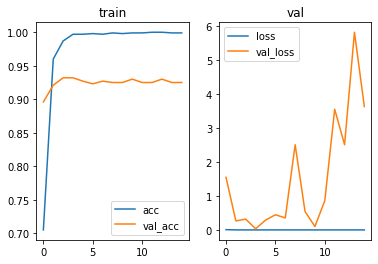

In [ ]:
# plot
plt.subplot(121)
plt.plot(range(EPOCHS),stats['acc'], label="acc",)
plt.plot(range(EPOCHS),stats['val_acc'], label="val_acc")
plt.title("train"); plt.legend()

plt.subplot(122)
plt.plot(range(EPOCHS),stats['loss'], label="loss")
plt.plot(range(EPOCHS),stats['val_loss'], label="val_loss")
plt.title("val"); plt.legend()

plt.show()